In [62]:
from openpyxl import load_workbook, Workbook
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def get_data(subdirs):
    rootdir ='/media/mtezcan/New Volume/amazon/notebook/runs/'


    ground_truth = np.zeros(50000)
    prediction = np.zeros(50000)
    probabilities = np.zeros((9,50000))
    count = 0
    for subdir in subdirs:
        cdir = rootdir+subdir+'/val.xlsx'
        print(cdir)

        wb = load_workbook(filename=cdir, read_only=True)
        ws = wb['Sheet']



        rows = list(ws.rows)[349:360]
        for k in range(len(rows[0])):
            ground_truth[count] = rows[0][k].value
            prediction[count] = rows[1][k].value
            for l in range(9):
                probabilities[l,count] = rows[l+2][k].value
            count += 1


    ground_truth = ground_truth[:count] + 1
    prediction = prediction[:count] + 1
    probabilities = probabilities[:,:count]
    
    return (ground_truth, prediction, probabilities)
        

In [3]:
subdirs = ['resnet18__sgd_1.0xsingle + 0.0Xmulti_November08  19:47:31',
           'resnet18__sgd_1.0xsingle + 0.0Xmulti_November08  19:41:39',
           'resnet18__sgd_1.0xsingle + 0.0Xmulti_November08  19:35:46',
           'resnet18__sgd_1.0xsingle + 0.0Xmulti_November08  19:29:56'
           ]

data_single = get_data(subdirs)

subdirs = ['resnet18__sgd_0.0xsingle + 1.0Xmulti_November08  20:10:56',
           'resnet18__sgd_0.0xsingle + 1.0Xmulti_November08  20:05:03',
           'resnet18__sgd_0.0xsingle + 1.0Xmulti_November08  19:59:12',
           'resnet18__sgd_0.0xsingle + 1.0Xmulti_November08  19:53:23'
           ]

data_multi = get_data(subdirs)

subdirs = ['resnet18__sgd_0.1xsingle + 0.9Xmulti_November08  20:16:48',
           'resnet18__sgd_0.1xsingle + 0.9Xmulti_November08  20:34:32',
           'resnet18__sgd_0.1xsingle + 0.9Xmulti_November08  20:28:38',
           'resnet18__sgd_0.1xsingle + 0.9Xmulti_November08  20:22:45'
           ]

data_mix = get_data(subdirs)

/media/mtezcan/New Volume/amazon/notebook/runs/resnet18__sgd_1.0xsingle + 0.0Xmulti_November08  19:47:31/val.xlsx
/media/mtezcan/New Volume/amazon/notebook/runs/resnet18__sgd_1.0xsingle + 0.0Xmulti_November08  19:41:39/val.xlsx
/media/mtezcan/New Volume/amazon/notebook/runs/resnet18__sgd_1.0xsingle + 0.0Xmulti_November08  19:35:46/val.xlsx
/media/mtezcan/New Volume/amazon/notebook/runs/resnet18__sgd_1.0xsingle + 0.0Xmulti_November08  19:29:56/val.xlsx
/media/mtezcan/New Volume/amazon/notebook/runs/resnet18__sgd_0.0xsingle + 1.0Xmulti_November08  20:10:56/val.xlsx
/media/mtezcan/New Volume/amazon/notebook/runs/resnet18__sgd_0.0xsingle + 1.0Xmulti_November08  20:05:03/val.xlsx
/media/mtezcan/New Volume/amazon/notebook/runs/resnet18__sgd_0.0xsingle + 1.0Xmulti_November08  19:59:12/val.xlsx
/media/mtezcan/New Volume/amazon/notebook/runs/resnet18__sgd_0.0xsingle + 1.0Xmulti_November08  19:53:23/val.xlsx
/media/mtezcan/New Volume/amazon/notebook/runs/resnet18__sgd_0.1xsingle + 0.9Xmulti_Nove

In [ ]:
print(ground_truth.shape)
print(prediction.shape)
print(probabilities.shape)

In [4]:
def class_based_cir(data_f):

    err = data_f[0] - data_f[1]
    err_arr = np.zeros((4, 10))
    for cir in range(1, 10):
        err_cir = err[data_f[0] == cir]
        err_arr[0, cir-1] = np.mean(err_cir==0)
        err_arr[1, cir-1] = np.mean(np.abs(err_cir)<=1)
        err_arr[2, cir-1] = np.mean(np.abs(err_cir))
        err_arr[3, cir-1] = np.sqrt(np.mean(err_cir**2))

    err_arr[0, 9] = np.mean(err==0)
    err_arr[1, 9] = np.mean(np.abs(err)<=1)
    err_arr[2, 9] = np.mean(np.abs(err))
    err_arr[3, 9] = np.sqrt(np.mean(err**2))

    err_arr = np.round(err_arr,decimals = 2)
    return err_arr

In [71]:
err_single= class_based_cir(data_single)
err_multi= class_based_cir(data_multi)
err_mix= class_based_cir(data_mix)


wb = Workbook()
ws = wb.active

for err_arr in [err_single,err_multi,err_mix]:
    for err_k in err_arr.tolist():
        ws.append(err_k)

wb.save('./class_based.xlsx')

In [27]:
def conf_vs_metric(data_f,percentages = [.1*k for k in range(1,10)]):
    
    err = data_f[0] - data_f[1]
    confidence = np.max(data_f[2], axis = 0)
    conf_sorted = np.sort(confidence)
    idx = [int(percentage*len(confidence)) for percentage in percentages]

    conf_bins = [conf_sorted[k] for k in idx]
    #print(conf_bins)
    err_arr = np.zeros((4, len(conf_bins)))

    for k in range(len(conf_bins)):
        err_conf = err[confidence >= conf_bins[k]]
        err_arr[0, k] = np.mean(err_conf==0)
        err_arr[1, k] = np.mean(np.abs(err_conf)<=1)
        err_arr[2, k] = np.mean(np.abs(err_conf))
        err_arr[3, k] = np.sqrt(np.mean(err_conf**2))

    err_arr = np.round(err_arr,decimals = 2)
    return err_arr

In [73]:
conf_single= conf_vs_metric(data_single)
conf_multi= conf_vs_metric(data_multi)
conf_mix= conf_vs_metric(data_mix)

wb = Workbook()
ws = wb.active

for conf_arr in [conf_single,conf_multi,conf_mix]:
    for conf_k in conf_arr.tolist():
        ws.append(conf_k)

wb.save('./confidence.xlsx')

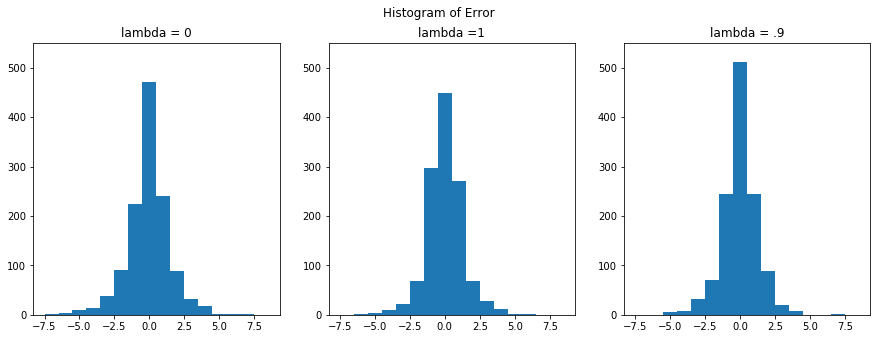

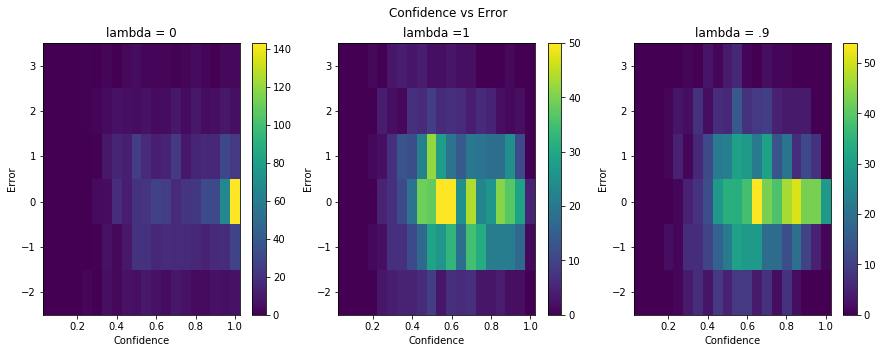

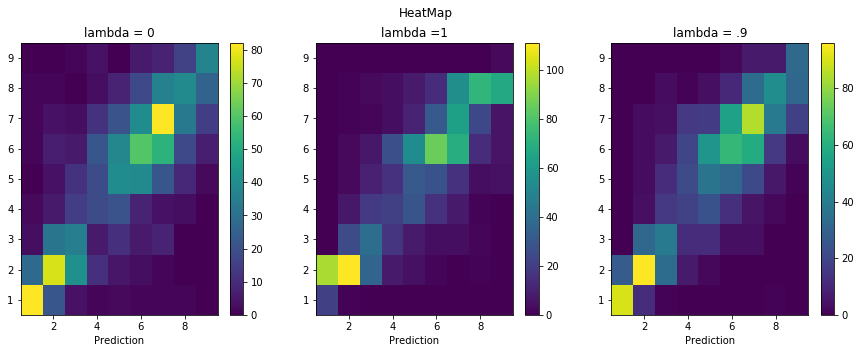

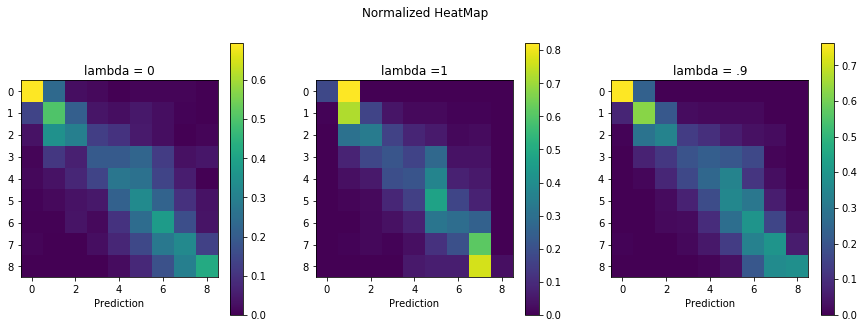

In [77]:
def plot_cir(data_fs,label):
    
    plt.figure(figsize=(15, 5))

    for k in range(len(data_fs)):
        data_f= data_fs[k]
        (ground_truth, prediction, probabilities) = data_f
        err = ground_truth - prediction
        confidence = np.max(probabilities, axis = 0)
        min_conf = np.min(confidence)
        
        plt.subplot(1,len(data_fs), k+1)
        plt.hist(err, bins = [k+.5 for k in range(-8,9)])
        plt.title(label[k])
        plt.ylim(0, 550)
    plt.suptitle('Histogram of Error')
    
    plt.figure(figsize=(15, 5))
    for k in range(len(data_fs)):
        data_f= data_fs[k]
        (ground_truth, prediction, probabilities) = data_f
        err = ground_truth - prediction
        confidence = np.max(probabilities, axis = 0)
        min_conf = np.min(confidence)
        
        plt.subplot(1,len(data_fs), k+1)
        plt.hist2d(confidence, err, bins=[[0.05*k+0.025 for k in range(0, 21)], [k+.5 for k in range(-3,4)]])
        plt.title(label[k])
        plt.xlabel('Confidence')
        plt.ylabel('Error')
        cbar = plt.colorbar()
    plt.suptitle('Confidence vs Error')
    
    plt.figure(figsize=(15, 5))
    for k in range(len(data_fs)):
        data_f= data_fs[k]
        (ground_truth, prediction, probabilities) = data_f
        err = ground_truth - prediction
        confidence = np.max(probabilities, axis = 0)
        min_conf = np.min(confidence)
        
        plt.subplot(1,len(data_fs), k+1)
        plt.hist2d(ground_truth, prediction, bins=[k+.5 for k in range(0,10)])
        plt.title(label[k])
        plt.xlabel('Ground truth')
        plt.xlabel('Prediction')
        cbar = plt.colorbar()
    plt.suptitle('HeatMap')
    
    plt.figure(figsize=(15, 5))
    for k in range(len(data_fs)):
        data_f= data_fs[k]
        (ground_truth, prediction, probabilities) = data_f
        err = ground_truth - prediction
        confidence = np.max(probabilities, axis = 0)
        min_conf = np.min(confidence)
        
        heat2d,_,_ = np.histogram2d(ground_truth, prediction, bins=[k+.5 for k in range(0,10)])
        heat2d_norm = heat2d/(np.sum(heat2d, axis = 1).reshape(-1,1)*np.ones((1,9)))
        
        plt.subplot(1,len(data_fs), k+1)
        plt.imshow(heat2d_norm)
        plt.colorbar()
        plt.title(label[k])
        plt.xlabel('Ground truth')
        plt.xlabel('Prediction')
    plt.suptitle('Normalized HeatMap')
        
plot_cir([data_single, data_multi, data_mix], ['lambda = 0', 'lambda =1', 'lambda = .9'])